# DDPG の実装

本章では DDPG の実装を扱っていきます．

本章では[Pendulum](https://www.gymlibrary.ml/environments/classic_control/pendulum/)環境に DDPG を適用していきます．
この環境は入力が 1 次元(振り子の軸についているモーターのトルク)で，出力が 3 次元(振り子の xy 座標 + 角速度)となっています．
報酬設計は

$$r = -(\theta^2 + 0.1  \dot{\theta}^2 + 0.001  \tau)$$

となっており，上で静止するほど報酬が大きくなる(0に近くなる)ようになっています．


/home/hisaki/workspace/ono-lab/rl-semi/.venv/lib/python3.8/site-packages/gym/utils/env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


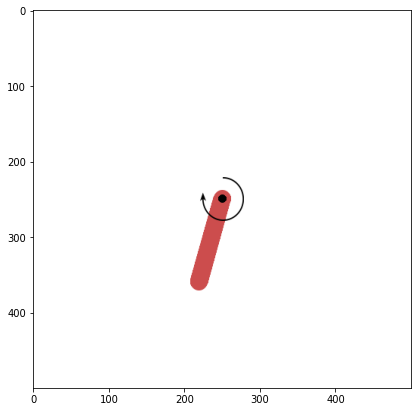

In [14]:
import gnwrapper
import gym

env = gnwrapper.LoopAnimation(gym.make("Pendulum-v1"))

while True:
    next_state, reward, done, info = env.step(env.action_space.sample())  # ランダムに行動
    env.render()  # 描画
    if done:
        break

env.display()

state_size = env.observation_space.shape[0]  # 状態の次元
action_size = env.action_space.shape[0]  # 行動の次元
GAMMA = 0.99 # 割引率

env = env.env


まずは，必要なモジュールを import や乱数シードの固定，デバイスの指定を行います．


In [2]:
from copy import deepcopy

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import random

# fix seed
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# デバイスを指定
# CUDAが使えるなら"cuda"に，無理なら"cpu"に
DEVICE = "cuda"
# DEVICE = "cpu"


[0]

## Replay Buffer の実装

まずは，Replay Buffer クラスを実装します．
このクラスは`append`関数で経験を保存し，`sample`で全経験からミニバッチを一様ランダムにサンプルします．


In [3]:
class ReplayBuffer(object):
    def __init__(self) -> None:
        self.memory = []

    def append(self, state, action, next_state, reward, done):
        """経験を保存する"""
        self.memory.append((state, action, next_state, reward, done))

    def sample(self, batch_size):
        """ミニバッチをサンプルする"""

        # ランダムに経験をサンプル
        sampled = random.sample(self.memory, batch_size)

        # ミニバッチを使いやすいようにdict形式のコンテナに入れる
        batch = dict(state=[], action=[], next_state=[], reward=[], done=[])

        for state, action, next_state, reward, done in sampled:
            batch["state"].append(state)
            batch["action"].append(action)
            batch["next_state"].append(next_state)
            batch["reward"].append(reward)
            batch["done"].append(done)

        # torch.Tensor型で経験を使うことが多いため，キャストを行う
        for key in batch.keys():
            batch[key] = torch.tensor(np.array(batch[key]), dtype=torch.float32, device=DEVICE)

        return batch


rb = ReplayBuffer()  # インスタンスを生成


## Actor/Critic の実装

実装上では，方策を`Actor`という名前で実装し，
方策を評価する行動価値関数を`Critic`という名前で実装します．

本節では

- 各ネットワーククラスを定義
- インスタンスを生成
- 最適化器のインスタンスの生成

を行います．

### Actor


In [4]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super().__init__()
        self.linear0 = nn.Linear(state_size, 400)
        self.relu0 = nn.ReLU()
        self.linear1 = nn.Linear(400, 300)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(300, action_size)
        self.tanh2 = nn.Tanh()

    def forward(self, state):
        """a = mu(s)"""
        h0 = self.relu0(self.linear0(state))
        h1 = self.relu1(self.linear1(h0))
        action = (
            self.tanh2(self.linear2(h1)) * 2.0
        )  # tanh(x)は[-1,1]の範囲だが，Pendulmの行動は[-2,2]となるため．
        return action


actor = Actor(state_size=state_size, action_size=action_size).to(DEVICE)  # actorのインスタンスを生成
actor_optimizer = Adam(actor.parameters(), 1e-3)  # 最適化のインスタンスを生成
actor_targ = deepcopy(actor).to(DEVICE).requires_grad_(
    False
)  # ターゲットネットワークの生成(勾配は計算しないのでrequires_grad_をFalseにする)

print(actor)


Actor(
  (linear0): Linear(in_features=3, out_features=400, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=400, out_features=300, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=300, out_features=1, bias=True)
  (tanh2): Tanh()
)


### Critic


In [5]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super().__init__()
        self.linear0 = nn.Linear(state_size + action_size, 400)
        self.relu0 = nn.ReLU()
        self.linear1 = nn.Linear(400, 300)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(300, action_size)

    def forward(self, state, action):
        """Q(s,a)"""
        sa = torch.cat([state, action], dim=1)  # 状態と行動の次元を結合
        h0 = self.relu0(self.linear0(sa))
        h1 = self.relu1(self.linear1(h0))
        y = self.linear2(h1)
        return y


critic = Critic(state_size=state_size, action_size=action_size).to(
    DEVICE
)  # criticのインスタンスを生成
critic_optimzer = Adam(critic.parameters(), 1e-3)  # 最適化のインスタンスを生成
critic_targ = (
    deepcopy(critic).to(DEVICE).requires_grad_(False)
)  # ターゲットネットワークの生成(勾配は計算しないのでrequires_grad_をFalseにする)

print(critic)


Critic(
  (linear0): Linear(in_features=4, out_features=400, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=400, out_features=300, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=300, out_features=1, bias=True)
)


## 損失関数の計算

### 行動価値関数の損失の計算

ミニバッチを引数にとり，返り値として行動価値関数の損失を返す関数を作成します．
{prf:ref}`ddpg`より，行動価値関数の損失は以下の式で計算されます．

$$\frac{1}{|B|}\sum_{(s,a,r,s') \in B} \left( q_{\phi}(s,a) - y(r,s') \right)^2,\\\text{where }y(r,s') = r + \gamma q_{\phi_{\text{targ}}}(s', \mu_{\theta_{\text{targ}}}(s'))$$

ただし，シミュレーション環境には終了状態が存在するため，{ref}`q-learning-impl`と同様の処理を考えます．
終了フラグ$\text{done}$($s'$が終了状態だと`True`)に対しターゲットは以下のようになります．

$$y(r,s') = r + \gamma (1-\text{done}) q_{\phi_{\text{targ}}}(s', \mu_{\theta_{\text{targ}}}(s'))$$

実装は以下のようになります．

In [6]:
def compute_loss_q(batch):
    """行動価値関数の損失を計算"""
    state, action, next_state, reward, done = (
        batch["state"],
        batch["action"],
        batch["next_state"],
        batch["reward"],
        batch["done"],
    )  # ミニバッチのデータを取り出す
    q_pred = critic(state, action).squeeze()  # q(s,a)を計算する

    with torch.no_grad():  # ターゲットの計算には勾配が不要
        next_action = actor_targ(next_state)  # a' = mu_targ(s')を計算
        y = (
            reward + GAMMA * (1 - done) * critic_targ(next_state, next_action).squeeze()
        )  # ターゲットを計算

    loss = F.mse_loss(q_pred, y)  # 損失を計算

    return loss


### 方策の損失を計算

ミニバッチを引数にとり，返り値として方策の損失を返す関数を作成します．
{prf:ref}`ddpg`より，方策の損失は以下の式で計算されます．

$$\frac{1}{|B|}\sum_{s \in B}q_{\phi}(s, \mu_{\theta}(s))$$

実装は以下のようになります．

In [7]:
def compute_loss_policy(batch):
    """方策の損失を計算"""
    state = batch["state"]
    action = actor(state)
    loss: torch.Tensor = -critic(state, action) # q(s,mu(s))の最大化を-q(s,mu(s))の最小化と捉える
    return loss.mean()


## 行動方策の定義

次に，行動方策を表す関数を定義します．
行動方策は，[ここの説明](ddpg_behavior_policy)より，現在の方策が最良とする行動にガウシアンノイズを加えたものです．
実際の行動には範囲が有るため，上下限でクリッピングを行います．

以下，現在の状態と加えるノイズの偏差を引数にとり，行動方策より行動を選択する関数を実装します．

In [8]:
def behavior_policy(state, noise_scale):
    """行動方策"""
    with torch.no_grad():  # 勾配計算の必要は無い
        action = actor(torch.tensor(state, device=DEVICE)).cpu().detach().numpy()
    action += noise_scale * np.random.randn(action_size)  # ノイズを加える
    action = np.clip(action, env.action_space.low, env.action_space.high)  # 行動を上下限内に収める
    return action


## ターゲットネットワークの更新

[DDPG のターゲットネットワーク](target_network)の節で解説したターゲットネットワークの更新を実装します．

方策，行動価値関数のターゲットネットワークは以下の式のように更新されます．

$$
\phi_{\text{targ}} &\leftarrow \rho \phi_{\text{targ}} + (1-\rho) \phi \\
\theta_{\text{targ}} &\leftarrow \rho \theta_{\text{targ}} + (1-\rho) \theta
$$

引数として，元のネットワークとターゲットネットワークとパラメータ$\rho$を受け取り，
ターゲットネットワークを更新する関数を定義します．

In [9]:
def delay_update(src: nn.Module, targ: nn.Module, rho: float):
    """ターゲットネットワークを遅れて更新"""
    for p, p_targ in zip(src.parameters(), targ.parameters()):
        p_targ.data.mul_(rho)
        p_targ.data.add_((1 - rho) * p.data)


## 学習

ここまで用意したものを用いて，{prf:ref}`ddpg`に従い学習ループを実装します．
細かい説明はコードのコメント内に記載します．
以下が実装となります．

In [16]:
def evaluate(env: gym.Env, actor: Actor):
    """
    実際にActorを用いて行動し，10エピソードでの報酬和の平均を得る．
    この関数を用いてActor(方策)の評価を行う．
    """
    rewards = []
    for i in range(10):
        state = env.reset()
        reward_sum = 0.0
        while True:
            action = actor(torch.tensor(state, device=DEVICE)).cpu().detach().numpy()
            next_state, reward, done, _ = env.step(action)
            reward_sum += reward

            if done:
                rewards.append(reward_sum)
                break
            else:
                state = next_state

    return np.mean(rewards)


In [17]:
train_step = 30000  # 全トレーニングステップ数
start_step = 5000  # start_stepまでは完全にランダムに行動する
start_update_step = 1000  # パラメータの更新を開始するステップ数
batch_size = 256  # バッチサイズ
rho = 0.995  # ターゲットネットワークの更新のパラメータ
noise_scale = 0.2  # 行動方策のノイズの偏差

eval_interval = 1000  # eval_intervalステップおきに方策を評価する
eval_log = []  # 評価値のログ

state = env.reset()

for step in range(train_step):  # 学習ループをtrain_step回まわす
    if step < start_step:
        action = env.action_space.sample()  # 学習初期は完全にランダムに行動する．
    else:
        action = behavior_policy(state, noise_scale)  # 行動方策で行動を選択

    next_state, reward, done, _ = env.step(action)  # 行動を実行

    rb.append(  # 経験を蓄積
        state=state,
        action=action,
        next_state=next_state,
        reward=reward,
        done=False
        if env._elapsed_steps == env._max_episode_steps
        else done,  # ステップが終了ステップに達していたら，次状態は終了していない
    )

    if step > start_update_step:  # 10000ステップ以降から更新を開始
        batch = rb.sample(batch_size=batch_size)  # ミニバッチをサンプル

        q_loss = compute_loss_q(batch)  # qの損失を計算
        critic_optimzer.zero_grad()  # パラメータの勾配を初期化
        q_loss.backward()  # 損失から勾配を計算
        critic_optimzer.step()  # 1ステップパラメータを更新する

        actor_optimizer.zero_grad()  # muの損失を計算
        policy_loss = compute_loss_policy(batch)  # パラメータの勾配を初期化
        policy_loss.backward()  # 損失から勾配を計算
        actor_optimizer.step()  # 1ステップパラメータを更新する

        with torch.no_grad():  # ターゲットネットワークを更新
            delay_update(critic, critic_targ, rho)
            delay_update(actor, actor_targ, rho)

    if step % eval_interval == 0:  # eval_intervalステップおきに評価値を計算
        score = evaluate(env, actor)
        print(f"step : {step}, score : {score}")
        eval_log.append(score)

    if done:
        state = env.reset()
    else:
        state = next_state


step : 0, score : -1318.547426060363
step : 1000, score : -1195.6741902657236
step : 2000, score : -1373.4653268996453
step : 3000, score : -574.0061574420937
step : 4000, score : -162.20285602748433


KeyboardInterrupt: 

ここで，注意点が3点あります．

1. 本実装において，探索をより重視するため，学習初期(学習ステップが`start_step`に到達するまで)は，完全にランダムに行動しています．
2. パラメータの更新を開始するのは，十分に経験を収集してから(学習ステップが`start_update_step`に到達してから)です．
3. シミュレーションは，エピソードの経過ステップ`env._elapsed_steps`が`env._max_episode_steps`に達したら`done`が`True`になり打ち切られてしまいます．しかし，この場合は`next_state`が終了状態に達したわけではないので，蓄積する経験では`done`を`False`にします．